### Курсовой проект

In [1]:
!pip install luigi

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import luigi
import pickle
%matplotlib inline

import dask.dataframe as dd

from datetime import datetime, date, time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, roc_auc_score, confusion_matrix, make_scorer, roc_curve, auc

In [3]:
!luigid

2022-05-01 21:14:42,307 luigi[4688] INFO: logging configured by default settings
2022-05-01 21:14:42,308 luigi.scheduler[4688] INFO: No prior state file exists at /var/lib/luigi-server/state.pickle. Starting with empty state
Traceback (most recent call last):
  File "c:\users\uliana\anaconda3\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\users\uliana\anaconda3\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\Uliana\anaconda3\Scripts\luigid.exe\__main__.py", line 7, in <module>
  File "c:\users\uliana\anaconda3\lib\site-packages\luigi\cmdline.py", line 37, in luigid
    luigi.server.run(api_port=opts.port, address=opts.address, unix_socket=opts.unix_socket)
  File "c:\users\uliana\anaconda3\lib\site-packages\luigi\server.py", line 343, in run
    _init_api(
  File "c:\users\uliana\anaconda3\lib\site-packages\luigi\server.py", line 325, in _init_api
    api_sockets = tornado.netutil.bind_sockets(

In [4]:
train_df = pd.read_csv('../data/data_train.csv')
test_df = pd.read_csv('../data/data_test.csv')

In [5]:
train_df.head(3)

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0


In [6]:
train_df.dtypes

Unnamed: 0      int64
id              int64
vas_id        float64
buy_time        int64
target        float64
dtype: object

In [7]:
test_df.dtypes

Unnamed: 0      int64
id              int64
vas_id        float64
buy_time        int64
dtype: object

In [8]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [9]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 31.73 MB
Memory usage after optimization is: 12.69 MB
Decreased by 60.0%
Memory usage of dataframe is 2.17 MB
Memory usage after optimization is: 0.95 MB
Decreased by 56.2%


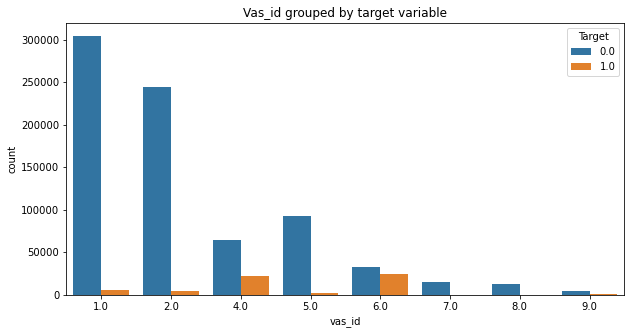

In [10]:
plt.figure(figsize=(10, 5))

sns.countplot(x="vas_id", hue=train_df['target'], data=train_df)
plt.title('Vas_id grouped by target variable')
plt.legend(title='Target', loc='upper right')
plt.savefig("vas_id-target2.png")

plt.show()


Разному количеству абонентов предлагались разные услуги, зависимость подключенных услуг и отказов тоже отличается.


C:\Users\Uliana\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


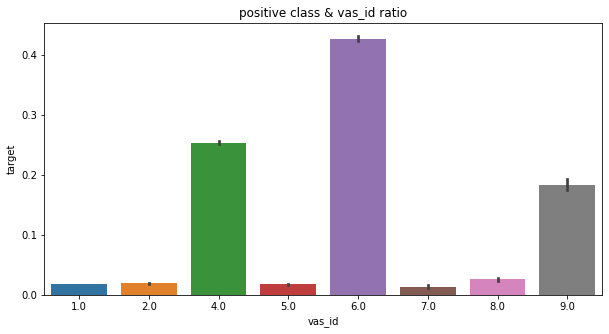

In [11]:
plt.figure(figsize=(10, 5))

sns.barplot("vas_id", 'target', data=train_df)
plt.title('positive class & vas_id ratio')
plt.savefig("vas_id-target.png")
plt.show()

Тут видим количество подключений и отказов, не зависящих от кол-ва предложений абонентам.

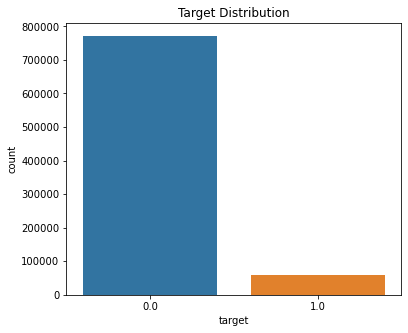

In [12]:
plt.figure(figsize=(6, 5))
plt.title('Target Distribution')

sns.countplot(x='target', data=train_df)
plt.savefig("target.png")

Здесь диаграмма показывает большую разницу между классами, что может негативно повлиять на результат. 

Фиксим датасет

In [13]:
def process_featues(data_features, train, test):
    ids = np.unique(train['id'].append(test['id']))
    # Интересуют id пользователей, встречающиеся в трейн и тест выборках.
    data_features = data_features[data_features['id'].isin(ids)]
    # Избавляемся от Unnamed
    if 'Unnamed: 0' in data_features:
        data_features = data_features.drop(columns='Unnamed: 0')

    data_features = data_features.compute()
    # удалим признаки с уникальным значением
    df_nunique = data_features.apply(lambda x: x.nunique(dropna=False))
    const = df_nunique[df_nunique ==1].index.tolist()
    data_features = data_features.drop(columns = const)
    # функция сжатия данных
    data_features = reduce_mem_usage(data_features)
    return data_features

In [14]:
features_df = dd.read_csv('../data/features.csv', sep ='\t')
features_df = process_featues(features_df, train_df, test_df)

Memory usage of dataframe is 1728.06 MB
Memory usage after optimization is: 528.40 MB
Decreased by 69.4%


In [15]:
features_df.corr()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
id,1.000000,0.074840,-0.018533,-0.049811,-0.019042,-0.047225,-0.020980,-0.048451,-0.005416,-0.015210,...,0.033406,0.031321,0.001759,0.018031,0.016822,0.007157,-0.003176,-0.001042,-0.002227,-0.011229
buy_time,0.074840,1.000000,-0.020798,-0.056733,-0.020246,-0.050396,-0.027111,-0.061522,-0.011254,-0.022163,...,0.018509,0.020754,0.002012,0.047451,0.027486,0.008100,-0.001095,-0.049700,-0.003440,-0.009546
0,-0.018533,-0.020798,1.000000,0.606258,0.986887,0.552520,0.962788,0.519619,0.835224,0.570514,...,0.028643,0.023416,0.003050,0.014586,0.025774,0.007121,0.012430,0.005131,0.006638,0.009441
1,-0.049811,-0.056733,0.606258,1.000000,0.609666,0.921309,0.609544,0.883710,0.543299,0.773935,...,0.088666,0.068011,0.009458,0.037165,0.072574,0.027004,0.032468,0.017403,0.016266,0.022717
2,-0.019042,-0.020246,0.986887,0.609666,1.000000,0.589568,0.975765,0.554173,0.819100,0.562351,...,0.036187,0.029072,0.003154,0.016948,0.028667,0.007831,0.012951,0.005395,0.006647,0.010343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0.007157,0.008100,0.007121,0.027004,0.007831,0.025493,0.007109,0.022467,0.007797,0.026552,...,0.066017,0.056394,0.009218,0.044098,0.093404,1.000000,0.045303,0.769158,0.052841,-0.001159
249,-0.003176,-0.001095,0.012430,0.032468,0.012951,0.030157,0.014713,0.032222,0.006223,0.018124,...,0.037465,0.032318,0.008102,0.016771,0.052640,0.045303,1.000000,0.007039,0.014803,0.002277
250,-0.001042,-0.049700,0.005131,0.017403,0.005395,0.016094,0.005104,0.014679,0.005002,0.016517,...,0.034466,0.030270,0.004284,0.006996,0.043271,0.769158,0.007039,1.000000,0.006693,-0.000335
251,-0.002227,-0.003440,0.006638,0.016266,0.006647,0.014722,0.006858,0.014480,0.004034,0.012479,...,0.010825,0.007913,0.002839,0.007966,0.024172,0.052841,0.014803,0.006693,1.000000,0.000849


In [16]:
merged_df = train_df.merge(features_df, on='id', how = 'left')
merged_df[merged_df.columns[6:]].loc[merged_df.target==1].describe() - merged_df[merged_df.columns[6:]].loc[merged_df.target==0].describe()

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
count,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,...,-735638.000000,-735638.000000,-735638.000000,-735638.0,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.000000,-735638.0
mean,1.532025,6.601340,1.907753,7.728915,2.441044,8.733985,0.584236,0.821314,0.176002,0.065152,...,-16.987147,-11.406881,17.005391,NaN,-7.624698,-1.431079,-0.015259,-0.482800,0.022779,NaN
std,-115.818634,-116.580811,-111.325851,-124.164093,-105.878387,-105.638031,-164.237175,-165.923264,-57.186897,-40.449219,...,-112.955322,-24.950439,3219.347229,NaN,-156.264648,-81.471893,NaN,-94.440651,NaN,NaN
min,504.250061,913.840027,1990.260010,1027.019958,1990.260071,1027.019958,444.049988,211.859985,307.316460,638.147858,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,5.119995,0.000000,4.760010,0.000000,5.509995,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.029999,6.789997,0.430000,5.409996,0.519997,6.300003,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,1.365001,11.235001,1.680000,10.614998,2.155001,12.925003,0.000000,0.000000,0.000000,0.000000,...,-19.000000,-12.000000,0.000000,0.0,-3.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,-206867.108887,-198202.564453,-206858.642090,-197761.077148,-205815.033691,-189596.708984,-206915.593750,-198841.191406,-85273.932373,-75992.851562,...,-150726.000000,-72802.007812,765225.000000,-8224.0,-135671.996094,-115549.003906,-3123.500000,-121941.003906,-9080.500000,-1561.0


In [17]:
del merged_df

Многие признаки достаточо сильно коррелируют между собой, соответственно, некоторые из них можно убрать.

Распределение многих признаков схожи: значения 25, 50, 75 перцинтилей одинаковы, средние отличаются незначительно, минимальные и максимальные значения отличаются в большей степени.

Нужно попробовать отобрать только необходимые признаки, чтобы убыстрить работу модели.

Подготовка датасета

In [18]:
X = train_df.drop('target', axis=1)
y = train_df['target']

In [19]:
class DataTransform(BaseEstimator, TransformerMixin):

    def __init__(self, features):
        self.data = None
        self.target = None
        self.features = features.copy()
        self.vas_id_dict1 = None
        self.vas_id_dict2 = None
        self.vas_id_dict3 = None
        self.q_list = None
        self.first_day = None


        
    def fit(self, data, target):
        self.data = data.copy()
        self.target = target.astype('int')
        X = pd.concat([data, target], axis=1)
        # доля подключений услуги по сравнению с отказами
        self.vas_id_dict1 = dict(X.groupby('vas_id')['target'].mean())
        # соотношение подключений по всем услугам
        self.vas_id_dict2 = dict(X.loc[X['target']==1]['vas_id'].value_counts(normalize=True))
        # доля предложений услуги
        self.vas_id_dict3 = dict(X['vas_id'].value_counts(normalize=True))
        #максимальные 20% значений по признакам из features
        self.q_list = [np.quantile(self.features[el], q=0.8) for el in self.features][2:]
        self.first_day = data['buy_time'].min()
        

        return self
    
    def transform(self, data):
   
        if 'Unnamed: 0' in data.columns:
            data.drop(columns='Unnamed: 0', inplace=True)
        data = reduce_mem_usage(data)
        
        # при сравнении распределения признаков в зависимости от целевой переменной в таблице выше видно, что
        # наибольшая разница наблюдается верхнем квартиле. Посчитаем значения выше 0.8 квантиля
        self.features['highest_value'] = 0
        for i, col in enumerate(self.features.columns[2:-1]):
            self.features.loc[self.features[col] > self.q_list[i], 'highest_value'] +=1
        
        
        self.features.drop_duplicates('id', keep='first', inplace=True)
        prepared_df = pd.merge(data, self.features, how='left', on='id')
        
        prepared_df.rename(columns={'buy_time_x': 'buy_time'}, inplace=True)
        

        # будем считать кол-во дней с 1го дня train периода
        prepared_df['count_days'] = (prepared_df['buy_time'] - self.first_day) //86400
        
        # доля подключений услуги по сравнению с отказами
        prepared_df['vas_id1'] = prepared_df['vas_id'].replace(self.vas_id_dict1)
        
        prepared_df['day'] = prepared_df['buy_time'].apply(lambda x: date.fromtimestamp(x).day)
        prepared_df['weekofyear'] = prepared_df['buy_time'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
        
        
        """
        Некоторым пользователям сделано несколько предложений. Сохраним информацию, какую услугу пользователю
        уже предлагали (каждую отдельно), сколько у него всего предложений, в какой последовательности предлагали
        услуги, какая разница по времени между предложениями услуг
        
        """
        tmp = prepared_df[['id', 'buy_time', 'vas_id']].merge(self.data[['id', 'buy_time', 'vas_id']],\
                                                              on=['id', 'buy_time', 'vas_id'], how='outer')
        tmp = tmp.loc[tmp['id'].isin(prepared_df['id'])]
        tmp2 = tmp.groupby('id')['vas_id'].count().reset_index()
        tmp2 = tmp2.loc[tmp2['vas_id']>1]
        tmp['buy_time'] = (tmp['buy_time'] - self.first_day) //86400
        tmp.rename(columns={'buy_time': 'count_days'}, inplace=True)
        # будем считать предложения только для тех пользователей, у которых их больше 1
        tmp = tmp.loc[tmp['id'].isin(tmp2['id'])].sort_values(['id', 'count_days']).reset_index(drop=True)
        tmp['1.0'] = 0 
        tmp['2.0'] = 0
        tmp['4.0'] = 0
        tmp['5.0'] = 0
        tmp['6.0'] = 0
        tmp['7.0'] = 0
        tmp['8.0'] = 0
        tmp['9.0'] = 0
        
        checked_id = 0
        counter = 1
        tmp['count_offers'] = 1
        tmp['time_delta'] = 0

        for i in range(tmp.shape[0]):
            if tmp.iloc[i]['id'] != checked_id:
                checked_id = tmp.iloc[i]['id']
                counter = 1   
            else:
                counter +=1
                tmp.loc[i, 'count_offers'] = counter
                tmp.loc[i, 'time_delta'] = tmp.iloc[i]['count_days'] - tmp.iloc[i-1]['count_days']
            tmp.loc[i, str(tmp.iloc[i]['vas_id'])] +=1
                
        prepared_df = prepared_df.merge(tmp[['id', 'vas_id','count_days', 'count_offers','time_delta']],\
                                        on=['id', 'vas_id','count_days'], how='left')
        prepared_df = prepared_df.merge(tmp.groupby('id').agg({'1.0': 'sum', '2.0':'sum', '4.0': 'sum', 
                    '5.0':'sum', '6.0': 'sum', '7.0':'sum', '8.0': 'sum', '9.0':'sum'}).reset_index(), on='id', how='left')
        
        #остальным пользователям проставим 1 предложение
        prepared_df['count_offers'] = prepared_df['count_offers'].fillna(1)
        prepared_df['time_delta'] = prepared_df['time_delta'].fillna(0)
        prepared_df['1.0'] = prepared_df['1.0'].fillna(0).rename('offer_1')
        prepared_df['2.0'] = prepared_df['2.0'].fillna(0).rename('offer_2')
        prepared_df['4.0'] = prepared_df['4.0'].fillna(0).rename('offer_4')
        prepared_df['5.0'] = prepared_df['5.0'].fillna(0).rename('offer_5')
        prepared_df['6.0'] = prepared_df['6.0'].fillna(0).rename('offer_6')
        prepared_df['7.0'] = prepared_df['7.0'].fillna(0).rename('offer_7')
        prepared_df['8.0'] = prepared_df['8.0'].fillna(0).rename('offer_8')
        prepared_df['9.0'] = prepared_df['9.0'].fillna(0).rename('offer_9')

        
        prepared_df.drop(['id','buy_time'], axis=1, inplace=True)
        
               
        
        return prepared_df


Опытным путем удалось оставить: 10 количественных признаков после РСА, 1 категориальный признак и новые фичи оставляем как есть

In [20]:
num_features = features_df.columns[2:]
cat_features = ['vas_id']
bool_features = []
other_features = ['highest_value', 'count_days', 'vas_id1', 'day', 'weekofyear', 'count_offers',
       'time_delta', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0']

In [21]:
class PCA_transformer(BaseEstimator, TransformerMixin):

    def __init__(self, num_features):
        self.num_features = num_features
        # постепенно сократим кол-во компонент до 10
        self.steps = [80, 40, 25, 15, 10]
        self.X = None

    def fit(self, X, y=None):
        self.X = X.copy()
        return self

    def transform(self, X, y=None):
        data = X[self.num_features].copy()
        for step in self.steps:
            pca = PCA(n_components=step, svd_solver='full')
            data = pca.fit_transform(data)
        col_names = ['pca' + str(i) for i in range(len(data[0]))]

        return X.join(pd.DataFrame(data, columns=col_names))   

In [22]:
# обработка признаков разного типа в пайплайне

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содержит следующие колонки: %s" % cols_error)

class Bool_col(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.mode = None
        self.unique = None
        
    def fit(self, X, y=None):
        self.mode = X.mode()[0]
        self.unique = np.unique(X)
        return self
    
    def transform(self, X, y=None):
        for el in X:
            if el not in self.unique:
                el = self.mode
        zero = self.unique[0]
        X = np.where(X==zero, 0, 1)
        return X.reshape(len(X), 1)

In [23]:
pca_features = ['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7', 'pca8', 'pca9']

In [24]:
final_transformers = list()
    
cat_transformer = Pipeline([
                ('selector', ColumnSelector(cat_features)),
                ('ohe', OneHotEncoder(handle_unknown='ignore'))
            ])
final_transformers.append(('cat', cat_transformer))
    
num_transformer = Pipeline([
                ('selector', ColumnSelector(pca_features))
            ])

final_transformers.append(('num', num_transformer))
    

other_transformer = Pipeline([
                ('selector', ColumnSelector(other_features))
            ])

final_transformers.append(('other', other_transformer))


In [25]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [26]:
# пайплайн для подготовки датасета без классификатора
prep_pipeline = Pipeline([
   ('prepare', DataTransform(features_df)),
    ('pca_transformer', PCA_transformer(features_df.columns[2:])),
    ('features',feats)
])

In [27]:
prep_pipeline.fit(X, y)
data = prep_pipeline.transform(X)

Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%
Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%


In [28]:
#сохраняем полученные данные
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]
df = pd.DataFrame.sparse.from_spmatrix(data, columns = cols)
df['id'] = train_df['id']

In [29]:
df.to_csv('data.csv', index=False)

Обучение и выбор модели

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=13)

Сравнение 3-х моделей:
XGBClassifier
CatBoostClassifier
LGBMClassifier
Подбор параметров делаем с помощью GridsearchCV:

In [31]:
parameters = [{'max_depth': [11,12, 13] , 
               'n_estimators': [80, 100, 120],
               'num_leaves': [100, 121, 144],
               'learning_rate':[0.01, 0.045], 
               'reg_lambda': [0.2, 0.4,]}]

gridsearch = GridSearchCV(estimator= LGBMClassifier(objective='binary',
                     scale_pos_weight = 1.7935), param_grid=parameters,  
                          scoring=make_scorer(f1_score, average='macro'), cv=5)

In [32]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(objective='binary',
                                      scale_pos_weight=1.7935),
             param_grid=[{'learning_rate': [0.01, 0.045],
                          'max_depth': [11, 12, 13],
                          'n_estimators': [80, 100, 120],
                          'num_leaves': [100, 121, 144],
                          'reg_lambda': [0.2, 0.4]}],
             scoring=make_scorer(f1_score, average=macro))

In [33]:
gridsearch.best_params_

{'learning_rate': 0.045,
 'max_depth': 13,
 'n_estimators': 100,
 'num_leaves': 100,
 'reg_lambda': 0.2}

Обучение моделей с подобранными параметрами:

In [34]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred, threshold = 0.5):
    threshold = np.array([threshold])
    y_pred = (y_train_pred > threshold).astype(int)
    y_test_p = (y_test_pred > threshold).astype(int)
    print('TRAIN\n\n' + classification_report(y_train_true, y_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_p))

In [35]:
%%time

model_xgb = XGBClassifier(n_estimators=100,
                          max_depth=12,
                          learning_rate=0.045,
                          reg_lambda=0.4,
                          reg_alpha=0.4,
                          scale_pos_weight=3,
                          random_state=13,
                          eval_metric='logloss',
                          importance_type='weight')
model_xgb.fit(X_train, y_train)

C:\Users\Uliana\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Wall time: 4min 17s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              importance_type='weight', interaction_constraints='',
              learning_rate=0.045, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=13, reg_alpha=0.4, reg_lambda=0.4,
              scale_pos_weight=3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [36]:
xgb_train_proba = model_xgb.predict_proba(X_train)[:, 1]
xgb_test_proba = model_xgb.predict_proba(X_test)[:, 1]

In [37]:
get_classification_report(y_train, xgb_train_proba, y_test, xgb_test_proba, threshold = 0.55)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97    578600
         1.0       0.59      0.76      0.67     45139

    accuracy                           0.94    623739
   macro avg       0.79      0.86      0.82    623739
weighted avg       0.95      0.94      0.95    623739

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    192867
         1.0       0.54      0.70      0.61     15047

    accuracy                           0.93    207914
   macro avg       0.76      0.82      0.79    207914
weighted avg       0.94      0.93      0.94    207914



In [38]:
%%time

model_cb = CatBoostClassifier(silent=True, iterations=160, learning_rate=0.03, depth=7, l2_leaf_reg=4, 
                                auto_class_weights='Balanced', eval_metric='F1', early_stopping_rounds=50, 
                              random_state=42)
model_cb.fit(X_train, y_train)

Wall time: 28.1 s


In [39]:
cb_train_proba = model_cb.predict_proba(X_train)[:, 1]
cb_test_proba = model_cb.predict_proba(X_test)[:, 1]

In [40]:
get_classification_report(y_train, cb_train_proba,
                          y_test, cb_test_proba, threshold=0.83)

TRAIN

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.97    578600
         1.0       0.54      0.70      0.61     45139

    accuracy                           0.94    623739
   macro avg       0.76      0.83      0.79    623739
weighted avg       0.94      0.94      0.94    623739

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    192867
         1.0       0.54      0.70      0.61     15047

    accuracy                           0.94    207914
   macro avg       0.76      0.83      0.79    207914
weighted avg       0.94      0.94      0.94    207914



In [41]:
%%time

model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 1.7935,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

Wall time: 6.64 s


LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=1.7935)

In [42]:
lgb_train_proba = model_lgb.predict_proba(X_train)[:, 1]
lgb_test_proba = model_lgb.predict_proba(X_test)[:, 1]

In [43]:
get_classification_report(y_train, lgb_train_proba,
                          y_test, lgb_test_proba, threshold=0.49)

TRAIN

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    578600
         1.0       0.61      0.62      0.62     45139

    accuracy                           0.94    623739
   macro avg       0.79      0.80      0.79    623739
weighted avg       0.94      0.94      0.94    623739

TEST

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97    192867
         1.0       0.61      0.62      0.61     15047

    accuracy                           0.94    207914
   macro avg       0.79      0.79      0.79    207914
weighted avg       0.94      0.94      0.94    207914



In [44]:
predictions = {'XGBoost': xgb_test_proba, 'CatBoost': cb_test_proba, 'LGBM': lgb_test_proba}

XGBoost : AUC_PR = 0.702
XGBoost : AUC_ROC = 0.954
CatBoost : AUC_PR = 0.702
CatBoost : AUC_ROC = 0.955
LGBM : AUC_PR = 0.711
LGBM : AUC_ROC = 0.956


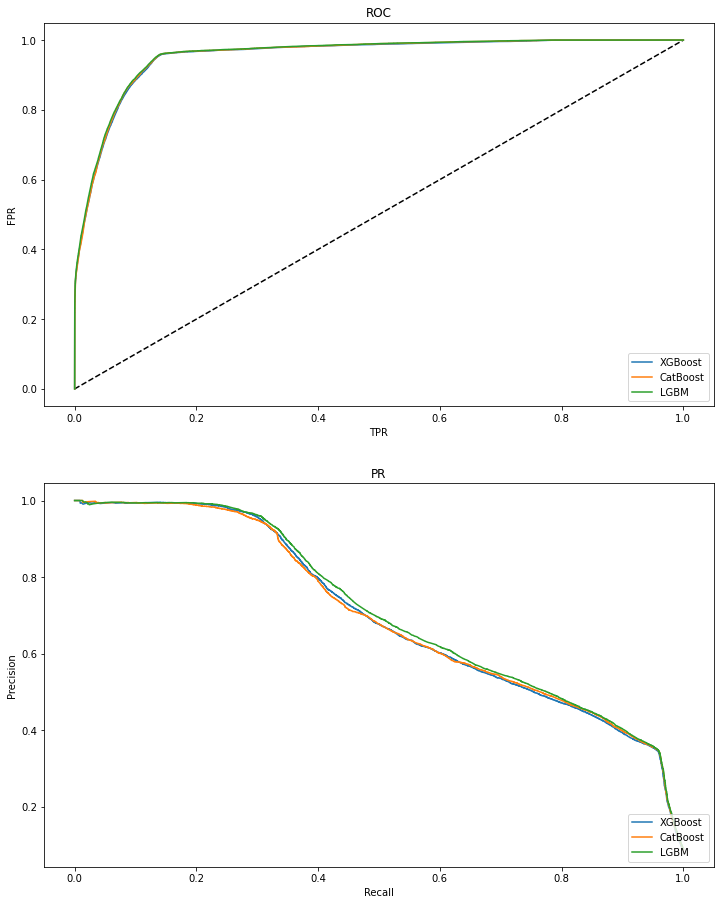

In [45]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(311)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(312)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

for key, value in predictions.items():
    fpr, tpr, roc_thresholds = roc_curve(y_test, value)
    precision, recall, pr_thresholds = precision_recall_curve(y_test, value)
    ax1.plot(fpr, tpr, label=key)
    ax2.plot(recall, precision, label=key)
    print(key, ": AUC_PR = %.3f" % auc(recall, precision))
    print(key, ": AUC_ROC = %.3f" % auc(fpr, tpr))
    
    
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");
plt.savefig("roc-pr.png")

Результаты плюс-минус одинаковые, но LGBM работает шустрее

In [46]:
def show_feature_importances(importances, feature_names, get_top):
    if get_top == None:
        get_top = len(feature_names)      
    feature_importances = pd.Series(importances, index=feature_names)
    feature_importances.nlargest(get_top).plot(kind='barh')
    plt.title(str(get_top) + " Feature Columns Importances")
    plt.show()

In [47]:
cols = ['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', *pca_features, *other_features]

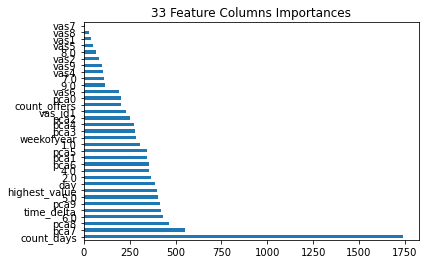

In [48]:
show_feature_importances(model_lgb.feature_importances_, cols, get_top=None)

In [49]:
# Проверка с помощью кросс-валидации:
cv_scores = cross_val_score(model_lgb, data, y, cv=6, scoring=make_scorer(f1_score, average='macro'))
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

CV score is 0.7898792338257268+-0.006142017556035707


In [50]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
      
    figure = plt.figure(figsize = (15, 6))

    plt1 = figure.add_subplot(121)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=0.5)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

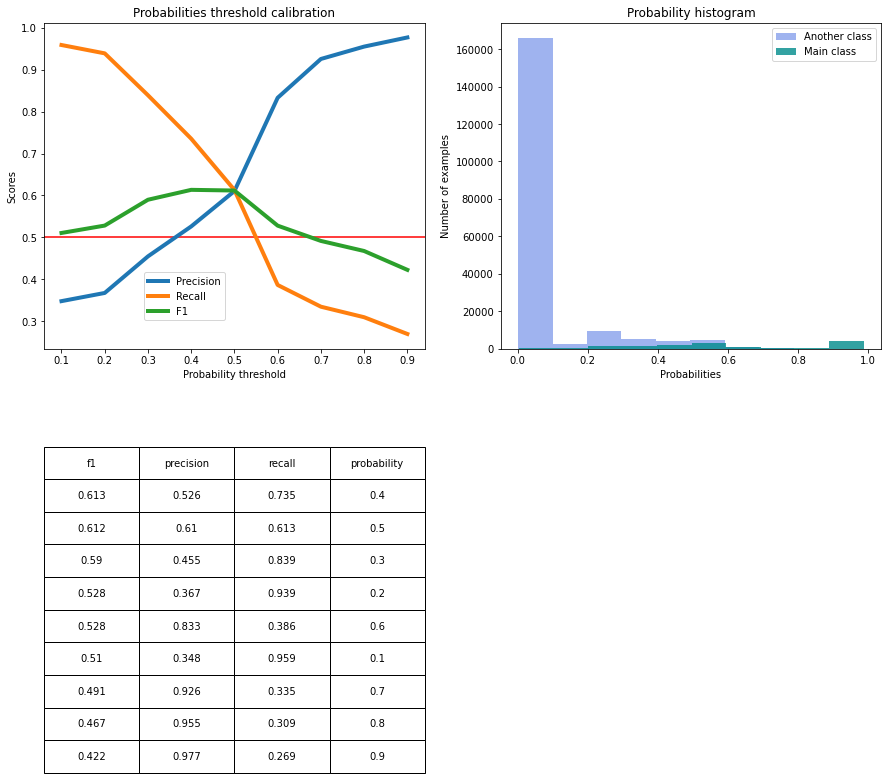

In [51]:
show_proba_calibration_plots(lgb_test_proba, y_test)

In [52]:
def plot_confusion_matrix(data, classes, title):
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))

    plt.rc('font', size=32)
    plt.rcParams["axes.labelsize"] = 26

    plt.title(title)

    sns.set(font_scale=2.3)
    ax = sns.heatmap(data, annot=True, cmap="YlGnBu", cbar=False, fmt='g')

    ax.set_xticklabels(classes, fontsize=22)
    ax.set_yticklabels(classes, fontsize=22)

    ax.set(ylabel="Reviewer Response", xlabel="True Value")

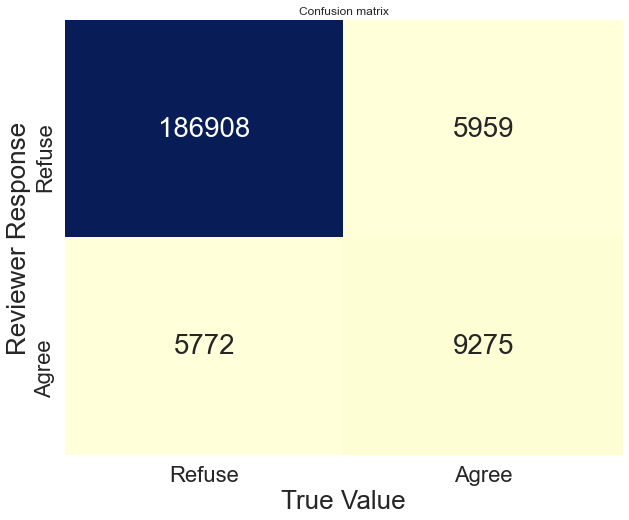

In [53]:
cnf_matrix = confusion_matrix(y_test, lgb_test_proba>0.49)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Refuse', 'Agree'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Сохраняем пайплайн

In [54]:
full_pipeline = Pipeline([
    ('prepare', DataTransform(features_df)),
    ('pca_transformer', PCA_transformer(features_df.columns[2:])),
    ('features',feats),
    ('classifier', LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2))
])

full_pipeline.fit(X, y)

Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%


Pipeline(steps=[('prepare',
                 DataTransform(features=            id    buy_time           0            1           2            3  \
13     2046132  1534712400  300.820038  1599.480835  286.879211  1585.013184   
16     2050810  1540760400  -86.209969    91.820885  -84.480789   110.333199   
19     2070757  1540760400  -96.799973  -408.179108 -110.740784  -460.786804   
20     2071522  1544994000  -94.939972  -363.699127 -108.880783  -411.226807   
22     2075318  1533502800  -75.639969   669.690918  -89...
                                                                                          'pca9']))])),
                                                ('other',
                                                 Pipeline(steps=[('selector',
                                                                  ColumnSelector(columns=['highest_value',
                                                                                          'count_days',
                     

In [55]:
lgb_train_proba = full_pipeline.predict_proba(X)[:, 1]

Memory usage of dataframe is 7.93 MB
Memory usage after optimization is: 7.93 MB
Decreased by 0.0%


In [56]:
print(classification_report(y, lgb_train_proba > 0.49))

              precision    recall  f1-score   support

         0.0       0.98      0.94      0.96    771467
         1.0       0.51      0.77      0.62     60186

    accuracy                           0.93    831653
   macro avg       0.75      0.86      0.79    831653
weighted avg       0.95      0.93      0.94    831653



In [57]:
with open("lgbm_pipeline.pickle", "wb") as f:
    pickle.dump(full_pipeline, f)

Сохраняем результат

In [58]:
class PredictProbability(luigi.Task):
    
    test_csv = luigi.Parameter()
    
  
    
    def run(self):
        
        test = pd.read_csv(self.test_csv, float_precision="high", encoding='utf8',sep=',')
        
      
        with open('lgbm_pipeline.pickle', 'rb') as model_file:
            model = pickle.load(model_file)
        

        test['target'] = model.predict_proba(test)[:, 1]
        
        
        test.to_csv('answers_test.csv', float_format='%20f', index=False, encoding='utf8',sep=',')
        
  

    def output(self):
        return luigi.LocalTarget('answers_test.csv')

In [59]:
if __name__ == '__main__':
    luigi.build([PredictProbability('data_test.csv')])

DEBUG: Checking if PredictProbability(test_csv=data_test.csv) is complete
INFO: Informed scheduler that task   PredictProbability_data_test_csv_b958939509   has status   DONE
INFO: Done scheduling tasks
INFO: Running Worker with 1 processes
DEBUG: Asking scheduler for work...
DEBUG: Done
DEBUG: There are no more tasks to run at this time
INFO: Worker Worker(salt=407389648, workers=1, host=LAPTOP-GL267VQB, username=Uliana, pid=1604) was stopped. Shutting down Keep-Alive thread
INFO: 
===== Luigi Execution Summary =====

Scheduled 1 tasks of which:
* 1 complete ones were encountered:
    - 1 PredictProbability(test_csv=data_test.csv)

Did not run any tasks
This progress looks :) because there were no failed tasks or missing dependencies

===== Luigi Execution Summary =====



In [60]:
answers = pd.read_csv('answers_test.csv')
answers.head(5)

,id,vas_id,buy_time,target
0,3130519,2.0,1548018000,0.001023
1,2000860,4.0,1548018000,0.424379
2,1099444,2.0,1546808400,0.000970
3,1343255,5.0,1547413200,0.000809
4,1277040,2.0,1546808400,0.001096


Персональные предложения

Кому будет интересна услуга? Оптимальный порог для f1-macro - 0.49. Нужно оптимальный порог для увеличения f1 именно по наименшему (позитивному) классу:

In [61]:
precision, recall, thresholds = precision_recall_curve(y_test, lgb_test_proba)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc_auc=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix], roc_auc_score(y_test, lgb_test_proba)))

Best Threshold=0.422771, F-Score=0.616, Precision=0.538, Recall=0.719, Roc_auc=0.956


In [62]:
confusion_matrix(y_test, lgb_test_proba>0.425)

array([[183635,   9232],
       [  4266,  10781]], dtype=int64)

Для ML оптимальным порогом определения целевого абонента является 0.425.

Но сейчас нужно учетывать экономические и маркетинговые приоритеты компании. Если компании важно охватить как можно больше клиентов, не упустить никого (увеличить recall), то порог нужно снизить. Если комапния не намерена тратить ресурсы на большое количество клиентов и заинтересована в том, чтобы ML-алгоритм макимально точно показал только тех клиентов, которые с максимальной вероятностью воспользуются услугой (увелилчить precision), порог следует повысить. Для того, чтобы предложить клиенту услугу, компании придется потратить деньги, поэтому обзванивать всех клиентов зачастую нецелесообразно. Чтобы определить, какой именно порог будет наиболее выгодным, можно подсчитать затраты на кандидата и прибыль с каждого true positive клиента.

В качестве упрощенного примера предположим, что затраты на кандидата = 1 доллар, а прибыль с true positive клиента = 2 доллара. Количество пороговых значений thresholds уменьшено для экономии времени.

In [63]:
expenses = 1
profit = 2
thresholds = np.linspace(0.3, 0.8, 51)

In [64]:
max_revenue = 0
best_t = 0
for t in thresholds:
    cnf_matrix = confusion_matrix(y_test, lgb_test_proba>t)
    add_summ = cnf_matrix[1,1]*profit - np.sum(cnf_matrix[:,1])*expenses
    if add_summ > max_revenue:
        max_revenue = add_summ
        best_t = t
print(f'Максимальный доход: {max_revenue} достигнут при пороге {best_t}')

Максимальный доход: 4686 достигнут при пороге 0.61


Если пользователь не согласится на данную услугу, его может заинтересовать другая.

Для решения этой задачи можно воспользоваться мультиклассовой классификацией, используя признак "vas_id" в качестве целефой переменной. Для этого возьмем предобработанные в пайплайне выше данные из data_train.csv и уберем оттуда новые признаки, зависящие непосредственно от 'vas_id'.

In [65]:
df = pd.read_csv('data.csv')

In [66]:
df = df.drop(['vas1', 'vas2', 'vas4', 'vas5', 'vas6', 'vas7', 'vas8', 'vas9', '1.0', '2.0', '4.0', '5.0', '6.0', '7.0',
 '8.0', '9.0', 'vas_id1'], axis=1)

In [67]:
df['vas_id'] = train_df['vas_id']

In [68]:
df.head(3)

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,highest_value,count_days,day,weekofyear,count_offers,time_delta,id,vas_id
0,7.989398e+08,-704943360.0,-123993656.0,-7744.557617,39455.261719,-2491.076904,-54931.000000,10516.652344,-620.426697,-2280.166260,40.0,70.0,17.0,38.0,1.0,0.0,540968,8.0
1,1.218476e+09,746920384.0,-193244048.0,42777.152344,-50203.914062,3918.010986,-15402.217773,-6944.403809,-5700.880859,-422.207916,23.0,7.0,16.0,29.0,1.0,0.0,1454121,4.0
2,-6.787219e+08,-264371536.0,-85790352.0,-130399.617188,118730.460938,-10253.109375,-60934.300781,-6358.808594,-6190.958008,-763.179749,5.0,35.0,13.0,33.0,1.0,0.0,2458816,1.0


In [69]:
# делим пользователей на кластеры
k8 = KMeans(n_clusters=8)
k8.fit(df)
df['kmeans'] =k8.predict(df)

In [70]:
result = LabelEncoder()
y = result.fit_transform(train_df['vas_id'])

In [71]:
# для обучения берем пользователей с подключенной услугой
df['target'] = train_df['target']
df['vas_id'] = y

df_train = df.loc[df.target==1]

In [72]:
X = df_train.drop(['vas_id', 'target'], axis=1)
y = df_train['vas_id']

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=13)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(45139, 18) (45139,) (15047, 18) (15047,)


In [74]:
X_id = X_test['id']
X_train = X_train.drop('id', axis=1)
X_test = X_test.drop('id', axis=1)

In [75]:
%%time

model_lgb = LGBMClassifier(objective='multiclass',
                     max_depth=10,
                     n_estimators=200,
                     num_leaves = 100,
                     learning_rate=0.045,
                     class_weight = 'balanced',
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

Wall time: 11.6 s


LGBMClassifier(class_weight='balanced', learning_rate=0.045, max_depth=10,
               n_estimators=200, num_leaves=100, objective='multiclass',
               reg_lambda=0.2)

In [76]:
preds = model_lgb.predict_proba(X_test)

In [77]:
df_preds = pd.DataFrame(preds, columns = ['1','2','4', '5','6','7','8', '9'])
df_preds['best_service'] = [df_preds.iloc[row].idxmax() for row in range(df_preds.shape[0])]
df_preds['id'] = X_id.values
df_preds = df_preds[['id', 'best_service','1','2','4', '5','6','7','8', '9' ]]

In [78]:
df_preds.best_service.value_counts(normalize=True)

6    0.396358
4    0.254868
1    0.116302
2    0.112248
5    0.058018
9    0.045059
8    0.011896
7    0.005250
Name: best_service, dtype: float64

Услуга №6 возглавила список по подключениям, вторая - услуга № 4, так же как и в первоначальном датасете data_train.csv, 
а по подключению услуг 7, 8 и 9 недостаточно наблюдений.

In [79]:
train_df[train_df.target==1]['vas_id'].value_counts()

6.0    24704
4.0    21765
1.0     5664
2.0     4797
5.0     1692
9.0     1004
8.0      347
7.0      213
Name: vas_id, dtype: int64

In [80]:
df_preds.loc[df_preds['id']==862975]

,id,best_service,1,2,4,5,6,7,8,9
7898,862975,8,0.06326,0.083756,0.036776,0.06415,0.006105,0.010403,0.654291,0.081259


Для абонента 862975 лучшей является услуга № 8

Если предлагать услугу № 1, то наиболее подходящие кандидаты будут:

In [81]:
df_preds.sort_values('1', ascending=False).head(3)

,id,best_service,1,2,4,5,6,7,8,9
9431,1302155,1,0.856869,0.009919,0.071238,0.040214,0.020330,0.000161,0.000394,0.000874
14176,3242547,1,0.832716,0.057599,0.049403,0.045112,0.004622,0.006202,0.000639,0.003707
11011,1286899,1,0.822169,0.035154,0.105150,0.019779,0.003811,0.004191,0.000611,0.009135


Бинарная классификация (выборка с одинаковыми данными об абонентах со всеми возможными 'vas_id') показывает, 
что некоторым пользователям не интересны никакие услуги, а другим интересны сразу несколько.

In [82]:
X_train = pd.concat([df, pd.get_dummies(train_df['vas_id'].astype('str'))], axis=1).drop(['target', 'vas_id', 'id'], axis=1)
y_train = df['target']

In [83]:
X_test['vas_id'] = 1

In [84]:
part = X_test.copy()
part['vas_id'] = 2
X_test = X_test.append(part)
part['vas_id'] = 4
X_test = X_test.append(part)
part['vas_id'] = 5
X_test = X_test.append(part)
part['vas_id'] = 6
X_test = X_test.append(part)
part['vas_id'] = 7
X_test = X_test.append(part)
part['vas_id'] = 8
X_test = X_test.append(part)
part['vas_id'] = 9
X_test = X_test.append(part)

X_test = pd.concat([X_test, pd.get_dummies(X_test['vas_id'].astype('str'))], axis=1)

In [85]:
results = pd.DataFrame()
results['id'] = np.append(X_id, [X_id, X_id, X_id, X_id, X_id, X_id, X_id])
results['vas_id'] = X_test['vas_id'].values

X_test.drop('vas_id', axis = 1, inplace=True)

In [86]:
model_lgb = LGBMClassifier(objective='binary',
                     max_depth=13,
                     n_estimators=100,
                     num_leaves = 100,
                     learning_rate=0.045,
                     scale_pos_weight = 2.86,
                     reg_lambda = 0.2)

model_lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.045, max_depth=13, num_leaves=100,
               objective='binary', reg_lambda=0.2, scale_pos_weight=2.86)

In [87]:
binary_preds = model_lgb.predict_proba(X_test)[:, 1]

In [88]:
results['preds']= binary_preds
results.head(5)

,id,vas_id,preds
0,1946568,1,0.040005
1,3951560,1,0.037914
2,367758,1,0.001116
3,817454,1,0.985681
4,1421442,1,0.001119


In [89]:
results.loc[results['id']==817454]

,id,vas_id,preds
3,817454,1,0.985681
15050,817454,2,0.985681
30097,817454,4,0.985395
45144,817454,5,0.985681
60191,817454,6,0.985028
75238,817454,7,0.985681
90285,817454,8,0.985681
105332,817454,9,0.985681


In [90]:
results.loc[results['id']==1946568]

,id,vas_id,preds
0,1946568,1,0.040005
15047,1946568,2,0.055264
30094,1946568,4,0.418244
45141,1946568,5,0.018342
60188,1946568,6,0.692253
75235,1946568,7,0.033181
90282,1946568,8,0.037064
105329,1946568,9,0.050384


1. Заметен значительный дисбаланс по количеству предложений разных услуг;

2. Непонятен критерий оптимально подобранной пары абонент-услуга. Если он подключил услугу, возможно, другую он тоже подключитьь был не против.

Определение абонентов для взаимодействия возможно методом UPLIFT. Некоторые негативно воспринимают любое взаимодействие с ними, другие лояльны и без дополнительных затрат на их удержание.

Решение по рекомендательным системам с библиотекой imlicit, не сработало. Возможно было бы иначе, если было бы больше абонентов с различными вариантами услуг.

In [91]:
train_df

,Unnamed: 0,id,vas_id,buy_time,target
0,0,540968,8.0,1537131600,0.0
1,1,1454121,4.0,1531688400,0.0
2,2,2458816,1.0,1534107600,0.0
3,3,3535012,5.0,1535922000,0.0
4,4,1693214,1.0,1535922000,0.0
...,...,...,...,...,...
831648,831648,3812226,2.0,1546203600,0.0
831649,831649,2480469,2.0,1546203600,0.0
831650,831650,158236,2.0,1546203600,0.0
831651,831651,1825525,2.0,1546203600,0.0


In [92]:
# Для фикса TypeError: No matching signature found вываливающегося из pd.pivot_table пришлось конверттировать 
# тип колонки 'target' обратно

train_df['target'] = train_df['target'].astype(np.float64) 

In [93]:
train_df.dtypes

Unnamed: 0      int32
id              int32
vas_id        float16
buy_time        int32
target        float64
dtype: object

In [94]:
user_item_matrix = pd.pivot_table(train_df,
                                          index='id',
                                          columns='vas_id',
                                          values='target',
                                          aggfunc='sum',
                                          fill_value=0
                                          )
user_item_matrix = user_item_matrix.astype(float)

In [95]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_userid = dict(zip(matrix_userids, userids))
id_to_itemid = dict(zip(matrix_itemids, itemids))

userid_to_id = dict(zip(userids, matrix_userids))
itemid_to_id = dict(zip(itemids, matrix_itemids))

In [96]:
model = AlternatingLeastSquares(factors=100,
                                        regularization=0.1,
                                        iterations=8,
                                        num_threads=15,
                                        calculate_training_loss=True)
model.fit(csr_matrix(user_item_matrix).T.tocsr())

C:\Users\Uliana\anaconda3\lib\site-packages\implicit\utils.py:26: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/8 [00:00<?, ?it/s]

In [140]:
def get_recommendations(user, model, N=2):
    res = [(id_to_itemid[rec[0]], rec[1]) for rec in
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=csr_matrix(user_item_matrix),
                                    N=N, 
                                    filter_already_liked_items=True, 
                                    filter_items=False, 
                                    recalculate_user=True)]
    return res

In [138]:
userid_to_id

{2: 0,
 4: 1,
 15: 2,
 16: 3,
 29: 4,
 30: 5,
 31: 6,
 36: 7,
 37: 8,
 39: 9,
 45: 10,
 48: 11,
 49: 12,
 52: 13,
 62: 14,
 64: 15,
 68: 16,
 70: 17,
 104: 18,
 109: 19,
 114: 20,
 119: 21,
 121: 22,
 122: 23,
 135: 24,
 137: 25,
 153: 26,
 161: 27,
 162: 28,
 163: 29,
 164: 30,
 171: 31,
 173: 32,
 174: 33,
 177: 34,
 182: 35,
 184: 36,
 187: 37,
 193: 38,
 197: 39,
 211: 40,
 231: 41,
 238: 42,
 247: 43,
 254: 44,
 257: 45,
 259: 46,
 260: 47,
 261: 48,
 262: 49,
 263: 50,
 266: 51,
 271: 52,
 272: 53,
 275: 54,
 293: 55,
 297: 56,
 298: 57,
 300: 58,
 301: 59,
 304: 60,
 316: 61,
 323: 62,
 331: 63,
 337: 64,
 338: 65,
 339: 66,
 341: 67,
 342: 68,
 343: 69,
 352: 70,
 355: 71,
 356: 72,
 363: 73,
 369: 74,
 372: 75,
 386: 76,
 389: 77,
 391: 78,
 397: 79,
 402: 80,
 404: 81,
 408: 82,
 409: 83,
 417: 84,
 418: 85,
 420: 86,
 426: 87,
 427: 88,
 441: 89,
 450: 90,
 456: 91,
 460: 92,
 461: 93,
 471: 94,
 473: 95,
 474: 96,
 476: 97,
 480: 98,
 487: 99,
 492: 100,
 496: 101,
 497: 10

In [141]:
get_recommendations(300, model=model, N=1)

ValueError: user_items must contain 1 row for every user in userids